### Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
import category_encoders as ce
from sklearn.impute import KNNImputer

print("Everything imported succesfully !")

Everything imported succesfully !


## Loading the data from csv file

- State FIPS: The Federal Information Processing Standards (FIPS) code for the state where the data pertains. It provides a unique identifier for each state in the dataset.
- Area Name: The name of the area or state specified by the State FIPS code. It represents the geographical region to which the occupational employment growth projections apply.
- Occupation Code: The code representing a specific occupation. It follows a standardized classification system (such as the Standard Occupational Classification - SOC) and uniquely identifies each occupation in the dataset.
- Occupation Name: The name or title of the occupation. It provides a descriptive label for each occupation specified by the Occupation Code.
- Base Year: The year for which the initial employment data is recorded or considered as the baseline. It represents the starting point for analyzing employment growth.
- Base: The number of employed individuals in the specified occupation during the Base Year. It represents the initial employment count for each occupation.
- Projected Year: The year for which the employment growth projection is made. It represents the future time point at which the projected employment numbers apply.
- Projection: The projected number of employed individuals in the specified occupation during the Projected Year. It represents the estimated employment count after the projected growth or change.
- Change: The absolute change in employment count between the Base Year and the Projected Year. It indicates the difference in the number of employed individuals for a specific occupation over the projection period.
- Percent Change: The percentage change in employment count between the Base Year and the Projected Year. It represents the relative growth or decline in employment for a particular occupation.
- Average Annual Openings: The average number of annual job openings expected for the specified occupation. It provides an estimate of the employment opportunities available each year due to factors like growth and replacement needs.d replacement needs.

In [2]:
# Let's load the data and explore it
df = pd.read_csv('dataset.csv')

### Exploratory data analysis ( Part 1 )s.

In [3]:
# Let's check the shape of the dataset
print("Shape of the dataframe : ",df.shape)

Shape of the dataframe :  (34982, 11)


In [4]:
# Let's check any 4 random rows from the dataset
df.sample(4)

,State FIPS,Area Name,Occupation Code,Occupation Name,Base Year,Base,Projected Year,Projection,Change,Percent Change,Average Annual Openings
7039,12,Florida,49-3052,Motorcycle Mechanics,2014,1320,2024,1660,340,26.3,60
30453,50,Vermont,11-2011,Advertising and Promotions Managers,2014,50,2024,50,0,4.4,0
34039,56,Wyoming,29-2054,Respiratory Therapy Technicians,2014,10,2024,10,0,-9.1,0
25289,41,Oregon,25-4011,Archivists,2014,70,2024,80,10,4.2,0


In [5]:
# Let's get some more basic infomraiton about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34982 entries, 0 to 34981
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   State FIPS               34982 non-null  int64  
 1   Area Name                34982 non-null  object 
 2   Occupation Code          34982 non-null  object 
 3   Occupation Name          34982 non-null  object 
 4   Base Year                34982 non-null  int64  
 5   Base                     34982 non-null  int64  
 6   Projected Year           34982 non-null  int64  
 7   Projection               34982 non-null  int64  
 8   Change                   34982 non-null  int64  
 9   Percent Change           34982 non-null  float64
 10  Average Annual Openings  34982 non-null  int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 2.9+ MB


In [7]:
int_cols = df.select_dtypes(include = np.int64)
float_cols = df.select_dtypes(include = np.float64)

# Changing the datatype from int43 or float64 to int32 or float32
df[int_cols.columns] = df[int_cols.columns].astype(np.int32)
df[float_cols.columns] = df[float_cols.columns].astype(np.float32)

- Before memory usage : 2.9mb
- After memory usage : 1.9mb

In [8]:
# Checking if there are any duplicated values
print("Duplicate values : ",df.duplicated().sum())

Duplicate values :  0


State FIPS                 0.0
Area Name                  0.0
Occupation Code            0.0
Occupation Name            0.0
Base Year                  0.0
Base                       0.0
Projected Year             0.0
Projection                 0.0
Change                     0.0
Percent Change             0.0
Average Annual Openings    0.0
dtype: float64


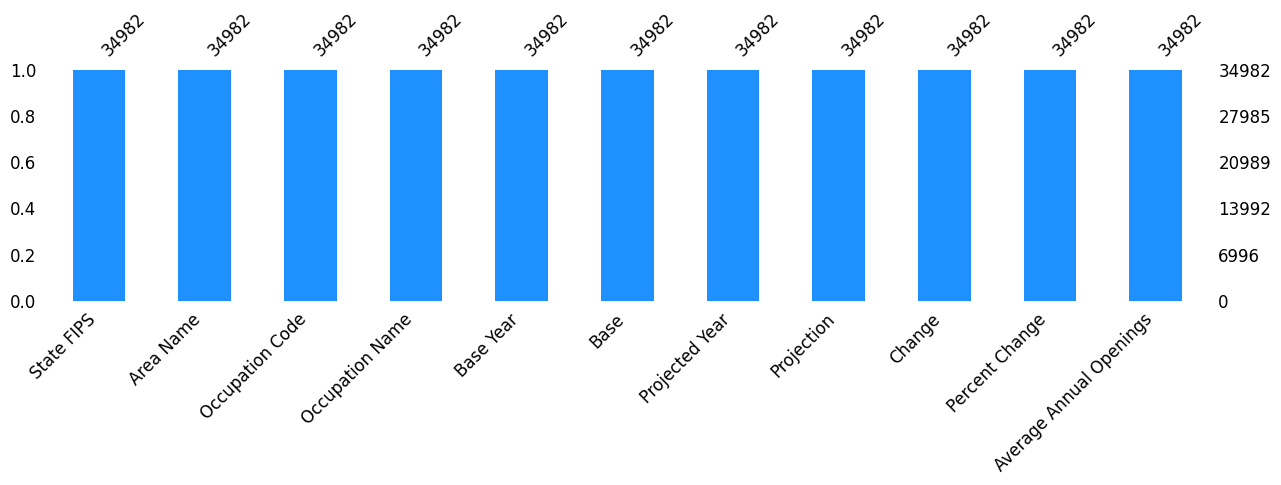

In [9]:
# Percentage of missing values
print(df.isnull().mean()*100)

# Visualize missing values using a bar chart
msno.bar(df,figsize = (15,3),color="dodgerblue", sort="ascending", fontsize=12)
plt.show()

In [15]:
# Removing all the rows from dataframe which are summary every area name
df.drop(df[df['Occupation Name'] == 'Total, All Occupations'].index,inplace=True)

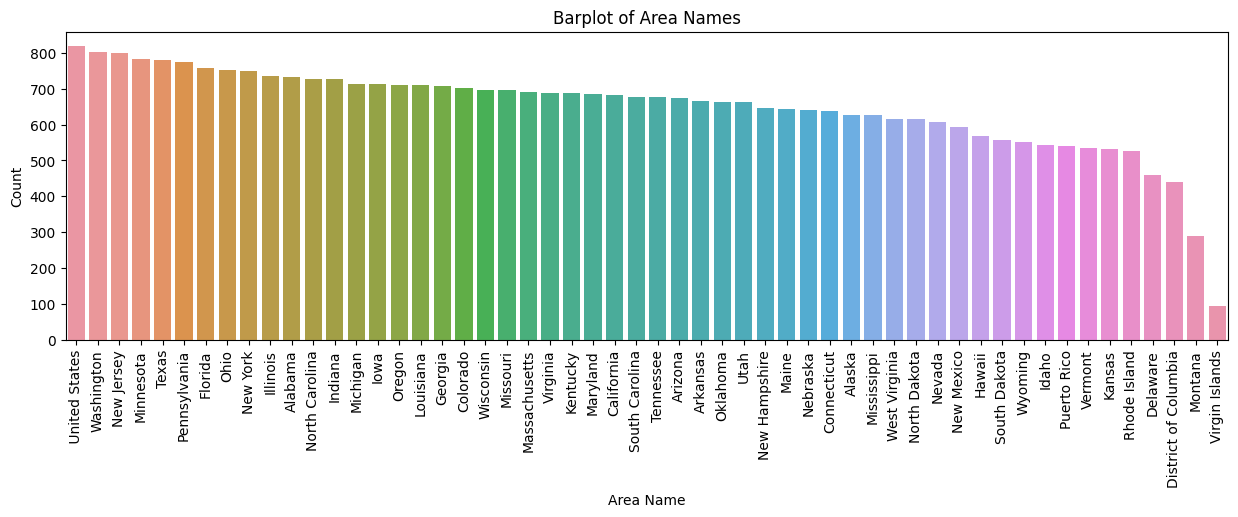

In [18]:
plt.figure(figsize=(15, 4))

# Plotting a bar plot to see data distribution across area names
ax = sns.barplot(y=df['Area Name'].value_counts().values, x=df['Area Name'].value_counts().index)

# Rotate the x-axis labels vertically
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.xlabel('Area Name')
plt.ylabel('Count')
plt.title('Barplot of Area Names')
plt.show()

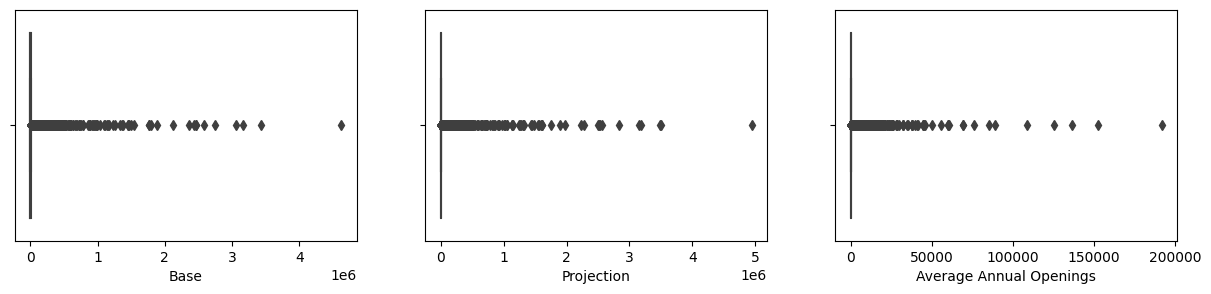

In [29]:
# Let's see if there are any outliers
fig,ax = plt.subplots(1,3,figsize = (15,3))

sns.boxplot(x = df['Base'],ax = ax[0])
sns.boxplot(x = df['Projection'],ax = ax[1])
sns.boxplot(x = df['Average Annual Openings'],ax = ax[2])

plt.show()

In [26]:
print("Total unique occupations are :",len(df['Occupation Name'].unique()))

Total unique occupations are : 819


### Data processing 

In this phase we only need to do the following things

- Drop unecessary columns
- Encode the categorical data
- Scale the feature values

In [34]:
# Removing the base-projected year instead creating a new column to represent the year difference
df['Year_difference'] = 10

In [37]:
# Removing the columns from the dataset
df.drop(['State FIPS','Occupation Code','Projected Year','Base Year'],axis = 1,inplace=True)

For the data processing we will create a pipeline but for now let's create a copy of the dataframe and on that copy we will explore all different kind of things and finally we will implemented best techniques on our actual dataset.

In [40]:
# Creating a copy of dataframe
temp_df = df.copy()

In our dataset in the occupation name there are some ocuppations which are similar such Advertising and Promotions Managers and  Marketing Manager, so insted of simply encoding this feature we will generate word embeddings which will capture semantic information.s

In [39]:
df['Occupation Name']

1                                         Chief Executives
2                          General and Operations Managers
3                                              Legislators
4                      Advertising and Promotions Managers
5                                       Marketing Managers
                               ...                        
34977                                 Driver/Sales Workers
34978             Light Truck or Delivery Services Drivers
34979                          Taxi Drivers and Chauffeurs
34980    Laborers and Freight, Stock, and Material Move...
34981                          Packers and Packagers, Hand
Name: Occupation Name, Length: 34928, dtype: object

In [38]:
df.head(3)

,Area Name,Occupation Name,Base,Projection,Change,Percent Change,Average Annual Openings,Year_difference
1,United States,Chief Executives,343400,339400,-4100,-1.2,5840,10
2,United States,General and Operations Managers,2124100,2275200,151100,7.1,68880,10
3,United States,Legislators,58300,57900,-400,-0.7,1290,10


In [10]:
# Let's drop the duplicate values
df.drop_duplicates(inplace=True)
print("Total duplicate values : ",df.duplicated().sum())

Total duplicate values :  0


### Dealing with missing values ( Less than 5% )
Out of all the features presnent in our dataset there are few features in which the percentage of missing valeus is less 5%, so we will first take those features we will simply compare the change in distribution of such features after removing or imputing missing values using simple univariate techniques.

In [11]:
# Let's see all feature having less than 5% missing values
for cols in df.columns:
    if df[cols].isnull().mean()*100 < 5 and df[cols].isnull().mean()*100 > 0:
        print(cols)

job
location
company_name
work_type
full_time_remote
no_of_employ
no_of_application
posted_day_ago
job_details


Since all the above features are categorical in nature so we will simply use mode imputation.

In [12]:
cols = ['job','location','company_name','work_type','full_time_remote','no_of_employ',
        'no_of_application','posted_day_ago','job_details']

# Mode imputation
for col in cols:
    df[col] = df[col].fillna(df[col].mode()[0])

Now since both alumni and linkedin_followers have 38% and 39% missing values so we will be using some advance techniques to deal with missing values such as KNN imputer. But for using KNN imputer we need to make sure that our categorical data is properly encoded so we first need to encode our categorical features and also we will not be using job and job details feature in KNN imputer.

Also we need to fix some features so we will first fix the features and then we will encode categorical features and finally we will use KNN imputer.

### Feature engineering

In [13]:
# Function to extract the followers count from 'linkedin_followers' column
followers_count = []
for i in range(len(df)):
    row = df['linkedin_followers'].iloc[i]
    if pd.isnull(row):
        followers_count.append(np.nan)
    elif 'followers' not in row:
        followers_count.append(np.nan)
    else:
        followers = row.split(' ')[0]
        followers = followers.replace(',', '')
        followers = int(followers)
        followers_count.append(followers)

df.drop(['linkedin_followers'],axis=1,inplace=True)
df['followers_count_HM'] = pd.Series(followers_count)

In [14]:
Alumni_count = []
for i in range(len(df)):
    item = df['alumni'].iloc[i]
    if isinstance(item, int):
        Alumni_count.append(item)
    elif isinstance(item, float):
        Alumni_count.append(np.nan)
    elif isinstance(item, str):
        item = item.split(' ')[0]
        item = item.replace(',', '')
        Alumni_count.append(int(item))   

df.drop(['alumni'],axis=1,inplace=True)
df['Alumni_count'] = pd.Series(Alumni_count)

In [15]:
Number_Of_Emp = []
for i in range(len(df)):
    item = df['no_of_employ'].iloc[i]
    if isinstance(item, float):
        Number_Of_Emp.append(item)
    elif isinstance(item,str):
        item = item.split(' ')[0]
        item = item.replace(',','')
        Number_Of_Emp.append(item)

df.drop(['no_of_employ'],axis=1,inplace=True)
df['Number_Of_Emp'] = pd.Series(Number_Of_Emp)

In [16]:
# Replace 'hours', 'minutes', and 'seconds' with NaN
df['no_of_application'].replace(['hours', 'minute', 'seconds','minutes','hour'], np.nan, inplace=True)

# Rename the 'full_time_remote' column to 'Employment_type'
df.rename(columns={'full_time_remote': 'Employment_type'}, inplace=True)

In [17]:
Posted_Minutes_Ago = []
for i in range(len(df)):
    item = df['posted_day_ago'].iloc[i]
    if isinstance(item, float):
        Posted_Minutes_Ago.append(np.nan)
    elif isinstance(item, str) and item.split(' ')[1] == 'hours':
        Posted_Minutes_Ago.append(int(item.split(' ')[0]) * 60)
    elif isinstance(item, str) and item.split(' ')[1] == 'minutes':
        Posted_Minutes_Ago.append(int(item.split(' ')[0]))
    elif isinstance(item, str) and item.split(' ')[1] == 'seconds':
        Posted_Minutes_Ago.append(int(item.split(' ')[0]) / 60)

df.drop(['posted_day_ago'],axis=1,inplace=True)
df['Posted_Minutes_Ago'] = pd.Series(Posted_Minutes_Ago)

In [18]:
# Fixing the Full time categorical values 
df['Employment_type'] = df['Employment_type'].str.replace('Full-time · Mid-Senior level', 'Full-time_Mid-Senior-Level')
df['Employment_type'] = df['Employment_type'].str.replace('Full-time · Associate', 'Full-time_Associate')
df['Employment_type'] = df['Employment_type'].str.replace('Full-time · Entry level', 'Full-time_Entry-Level')
df['Employment_type'] = df['Employment_type'].str.replace('Full-time · Executive', 'Full-time_Executive')
df['Employment_type'] = df['Employment_type'].str.replace('Full-time · Director', 'Full-time_Director')
df['Employment_type'] = df['Employment_type'].str.replace('Full-time · Internship', 'Full-time_Internship')

# Fixing the contract time categorical values 
df['Employment_type'] = df['Employment_type'].str.replace('Contract · Mid-Senior level', 'Contract_Mid-Senior-Level')
df['Employment_type'] = df['Employment_type'].str.replace('Contract · Associate', 'Contract_Associate')
df['Employment_type'] = df['Employment_type'].str.replace('Contract · Entry level', 'Contract_Entry-Level')
df['Employment_type'] = df['Employment_type'].str.replace('Contract · Executive', 'Contract_Executive')

# Fixing the part time categorical values
df['Employment_type'] = df['Employment_type'].str.replace('Part-time · Mid-Senior level', 'Part-time_Mid-Senior-Level')
df['Employment_type'] = df['Employment_type'].str.replace('Part-time · Associate', 'Part-time_Associate')

### Encoding categorical values

In [19]:
# Let's do ordinal encoding
emp_type = ['1-10 employees','11-50 employees','Associate','Contract','Contract_Associate','Contract_Entry-Level',
    'Contract_Executive','Contract_Mid-Senior-Level','Full-time','Full-time_Associate','Full-time_Director','Full-time_Entry-Level',
    'Full-time_Executive','Full-time_Internship','Full-time_Mid-Senior-Level','Internship','Internship · Entry level',
    'Internship · Internship','Part-time','Part-time_Associate''Part-time_Mid-Senior-Level','Temporary','Volunteer']

oe_et = OrdinalEncoder(categories = [emp_type],handle_unknown='use_encoded_value',unknown_value = np.nan)
df['Employment_type'] = pd.Series(oe_et.fit_transform(df['Employment_type'].values.reshape(-1,1)).reshape(-1))

In [20]:
cols = ['Number_Of_Emp','Employment_type']

# Mode imputation
for col in cols:
    df[col] = df[col].fillna(df[col].mode()[0])

Since our target variable number of application is having a lot of null values so instead of using it for target encoding let's try using the Employement_type for target encoding.

In [21]:
# Intializing the target encoder class
te_cn = ce.TargetEncoder(smoothing=0.2, handle_missing='value',handle_unknown='value',return_df=False)
te_wt = ce.TargetEncoder(smoothing=0.2, handle_missing='value',handle_unknown='value',return_df=False)

y = df['Employment_type'].values.reshape(-1,1)
df['company_name'] = pd.Series(te_cn.fit_transform(df['company_name'].values.reshape(-1,1),y).reshape(-1))
df['work_type'] = pd.Series(te_wt.fit_transform(df['work_type'].values.reshape(-1,1),y).reshape(-1))

In [22]:
cols = ['company_name','work_type']

# Mode imputation
for col in cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [23]:
# Let's seperate out the text data features
text_data = df[['job','job_details','location']]

df = df[['company_name', 'work_type', 'Employment_type','no_of_application','followers_count_HM',
       'Alumni_count', 'Number_Of_Emp', 'Posted_Minutes_Ago']]

In [24]:
print(df.isnull().mean()*100)

company_name           0.000000
work_type              0.000000
Employment_type        0.000000
no_of_application     39.948751
followers_count_HM    40.345932
Alumni_count          39.397822
Number_Of_Emp          0.000000
Posted_Minutes_Ago    38.744395
dtype: float64


In [27]:
imputer = KNNImputer(n_neighbors=5,metric='nan_euclidean')

df = imputer.fit_transform(df)

ValueError: could not convert string to float: 'days'

In [28]:
df

,company_name,work_type,Employment_type,no_of_application,followers_count_HM,Alumni_count,Number_Of_Emp,Posted_Minutes_Ago
0,11.195489,11.734797,9.0,200,5395547.0,12.0,1001-5000,480.0
1,11.195489,11.734797,9.0,184,5395547.0,12.0,1001-5000,480.0
2,11.561224,11.734797,14.0,200,NaN,3.0,1001-5000,540.0
3,11.238565,10.929882,8.0,200,2094.0,NaN,1-10,420.0
4,11.238565,10.929882,8.0,8,NaN,1.0,1-10,26.0
...,...,...,...,...,...,...,...,...
7922,11.238565,10.929882,14.0,25,NaN,NaN,1001-5000,NaN
7923,11.238565,10.929882,14.0,18,NaN,NaN,1001-5000,NaN
7924,11.238565,10.929882,14.0,15,NaN,NaN,1001-5000,NaN
7925,11.238565,10.929882,14.0,17,NaN,NaN,1001-5000,NaN


In [ ]:
cols = ['company_name','work_type']

# Mode imputation
for col in cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [25]:
for i in range(len(df)):
    item = df['Number_Of_Emp'].iloc[i]
    print(type(item))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class